# Comparative Analysis of Decision Tree Algorithms on IRIS Dataset

This notebook compares three decision tree algorithms (ID3, CART, and C5.0) on the IRIS dataset. We'll analyze their performance, interpretability, and characteristics to understand their strengths and weaknesses.

In [40]:
# Setup: Installing required packages
# This cell checks if all necessary libraries are installed and installs any missing ones
# It also provides instructions for installing system-level Graphviz which is needed for tree visualization

import sys
import subprocess

def install_package(package):
    try:
        print(f"Attempting to install {package}...")
        # Use --user flag to install in user directory, avoiding permission issues
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--user', package])
        print(f"Successfully installed {package}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package}: {e}")
        return False

# Try to import required packages, install if missing
required_packages = {
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'sklearn': 'scikit-learn',
    'graphviz': 'graphviz'
}

missing_packages = []
for module, package in required_packages.items():
    try:
        __import__(module)
        print(f"{module} is already installed.")
    except ImportError:
        print(f"{module} is not installed.")
        missing_packages.append(package)

# Install missing packages
if missing_packages:
    for package in missing_packages:
        install_package(package)
    print("\nAttempted to install all missing packages.")
else:
    print("All required Python packages are already installed!")

# Special note for graphviz system installation
try:
    import graphviz
    print("\nGraphviz Python package is available.")
except ImportError:
    print("\nUnable to import graphviz. Please try installing it manually:")
    print("pip install graphviz")

print("\nIMPORTANT NOTE:")
print("The 'graphviz' Python package requires the Graphviz software to be installed on your system.")
print("For Windows: Download and install from https://graphviz.org/download/")
print("Make sure to add Graphviz to your PATH during installation or manually add it after installation.")
print("After installing, restart your notebook kernel.")

numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
sklearn is already installed.
graphviz is already installed.
All required Python packages are already installed!

Graphviz Python package is available.

IMPORTANT NOTE:
The 'graphviz' Python package requires the Graphviz software to be installed on your system.
For Windows: Download and install from https://graphviz.org/download/
Make sure to add Graphviz to your PATH during installation or manually add it after installation.
After installing, restart your notebook kernel.


**Output Explanation:**

This cell checks your Python environment for the required packages and installs any missing ones. The output shows which packages are already installed in your environment. If graphviz is properly installed, you'll see "Graphviz Python package is available." The note also reminds you that besides the Python package, you need the actual Graphviz software installed on your system for tree visualizations to work.

## 1. Setup and Data Loading

In [41]:
# Importing Libraries
# This cell imports all the necessary libraries and modules for data analysis, visualization,
# and machine learning. It also sets a random seed for reproducibility.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import datasets
import graphviz
import sys
import os

# Add the utils directory to path
sys.path.append('..')
from utils.visualization import visualize_tree, plot_feature_importance, plot_confusion_matrices, plot_decision_boundaries

# Set random seed for reproducibility
np.random.seed(42)

In [42]:
# Loading the Iris Dataset
# This cell attempts to load the IRIS dataset from a local CSV file. If not found,
# it falls back to loading from sklearn's built-in datasets. It also prepares the 
# feature and target variables for modeling.

try:
    # Try to load from local CSV file
    iris_df = pd.read_csv('data/Iris.csv')
    print("Loaded IRIS dataset from local CSV file.")
    
    # Map species to numeric target values
    species_mapping = {
        'Iris-setosa': 0,
        'Iris-versicolor': 1,
        'Iris-virginica': 2
    }
    
    # Extract features and target
    feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
    iris_df['target'] = iris_df['Species'].map(species_mapping)
    X = iris_df[feature_names].values
    y = iris_df['target'].values
    
    # For consistency with sklearn naming convention
    feature_names_std = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    feature_name_mapping = dict(zip(feature_names, feature_names_std))
    
except FileNotFoundError:
    # If local file not found, load from sklearn
    print("Local CSV file not found. Loading IRIS dataset from sklearn.")
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    
    # Create a DataFrame for better visualization
    iris_df = pd.DataFrame(data=np.c_[iris.data, iris.target], 
                          columns=feature_names + ['target'])

# Set target names
target_names = ['setosa', 'versicolor', 'virginica']

# Add species column for better visualization
iris_df['species'] = iris_df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Drop the Id column if it exists
if 'Id' in iris_df.columns:
    iris_df = iris_df.drop('Id', axis=1)

# Display basic information
print(f"Dataset shape: {iris_df.shape}")
iris_df.head()

Loaded IRIS dataset from local CSV file.
Dataset shape: (150, 7)

Dataset shape: (150, 7)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,target,species
0,5.1,3.5,1.4,0.2,Iris-setosa,0,setosa
1,4.9,3.0,1.4,0.2,Iris-setosa,0,setosa
2,4.7,3.2,1.3,0.2,Iris-setosa,0,setosa
3,4.6,3.1,1.5,0.2,Iris-setosa,0,setosa
4,5.0,3.6,1.4,0.2,Iris-setosa,0,setosa


**Output Explanation:**

This output shows the first 5 rows of the Iris dataset. We can see that each row represents a single iris flower with 4 features (sepal length, sepal width, petal length, petal width) and its species classification. The dataset has been structured with both numerical target values (0, 1, 2) and the corresponding species names ('setosa', 'versicolor', 'virginica') for ease of use. The shape information tells us the dataset has 150 samples with multiple columns.

## 2. Data Exploration and Visualization

In [43]:
# Descriptive Statistics
# This cell calculates and displays basic statistical measures for the dataset,
# including count, mean, standard deviation, min, max, and percentiles for each feature.

iris_df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


**Output Explanation:**

The descriptive statistics above provide key insights about each feature in the dataset:

- **Count**: All features have 150 non-null values, confirming there are no missing values.
- **Mean & Standard Deviation**: Petal dimensions have greater variability (higher standard deviation relative to their means) than sepal dimensions, suggesting they might be more useful for classification.
- **Min/Max Range**: Petal length varies most dramatically (1.0-6.9cm) followed by petal width (0.1-2.5cm).
- **Quartiles (25%, 50%, 75%)**: The distribution of values across quartiles helps identify patterns. The large difference between quartiles for petal dimensions suggests clusters that might correspond to the different species.

In [44]:
# Checking for Missing Values
# This cell verifies if there are any missing (null) values in the dataset.
# Missing values would need to be handled before modeling.

print("Missing values in dataset:")
print(iris_df.isnull().sum())

Missing values in dataset:
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
target           0
species          0
dtype: int64


**Output Explanation:**

The output confirms that there are no missing values in the dataset. Each column has 0 missing values, which means the dataset is complete and we can proceed with our analysis without needing to handle missing data. This is ideal for training machine learning models as it eliminates the need for imputation or row deletion strategies.

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


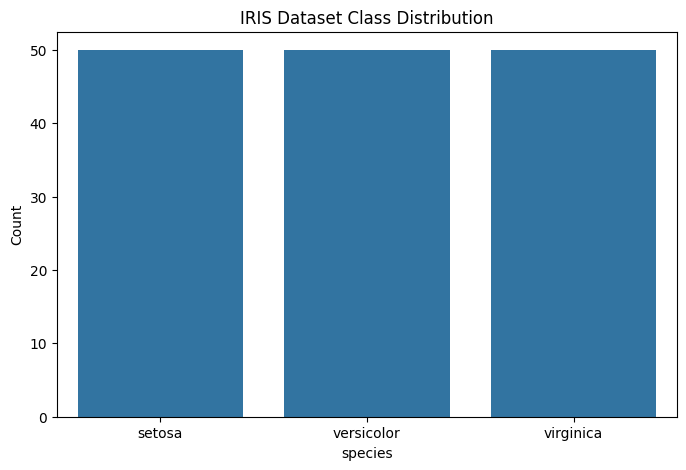

In [45]:
# Class Distribution Analysis
# This cell examines the distribution of classes (species) in the dataset and creates
# a bar chart to visualize the distribution, checking for class imbalance.

print("Class distribution:")
class_counts = iris_df['species'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='species', data=iris_df)
plt.title('IRIS Dataset Class Distribution')
plt.ylabel('Count')
plt.show()

**Output Explanation:**

The class distribution output and bar chart show that the Iris dataset is perfectly balanced, with exactly 50 samples of each species (setosa, versicolor, and virginica). This balanced distribution is ideal for machine learning as it ensures that the models won't be biased toward any particular class. Equal representation of classes helps in training robust models that perform well across all categories.

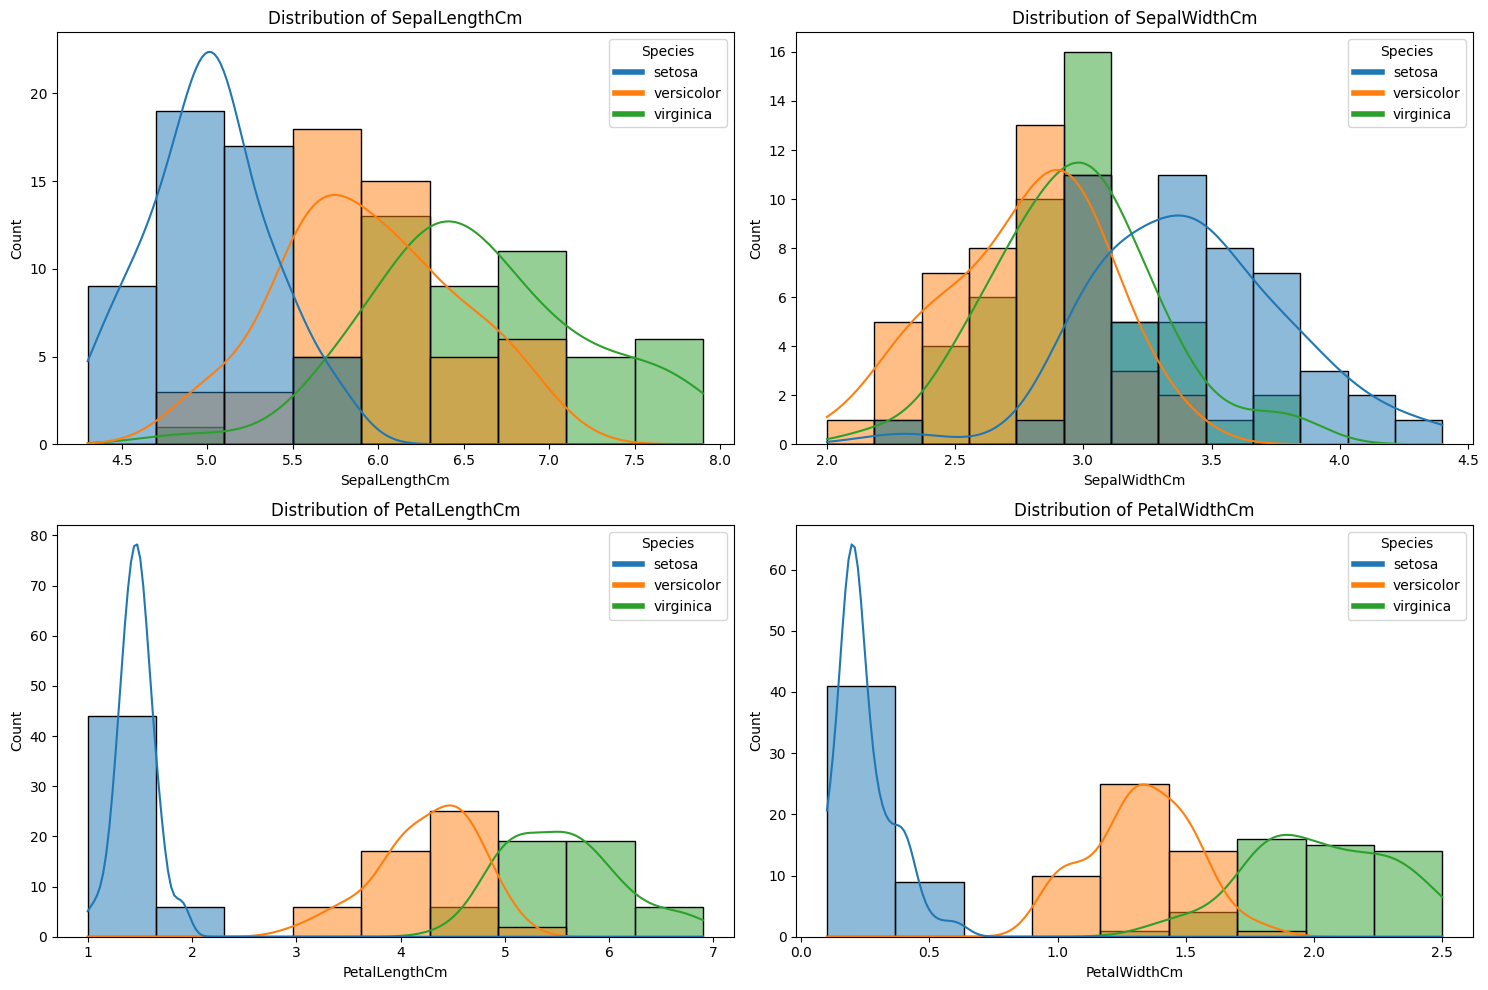

In [46]:
# Feature Distribution by Species
# This cell creates histograms for each feature, split by species, to show how
# the features are distributed across the three iris species. These plots help
# identify which features might be most useful for classification.

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Create a custom legend handle for each species
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=sns.color_palette()[0], lw=4, label='setosa'),
    Line2D([0], [0], color=sns.color_palette()[1], lw=4, label='versicolor'),
    Line2D([0], [0], color=sns.color_palette()[2], lw=4, label='virginica')
]

for i, feature in enumerate(feature_names):
    sns.histplot(data=iris_df, x=feature, hue='species', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    # Use custom legend instead of calling legend() directly on the axis
    axes[i].legend(handles=legend_elements, title='Species')

plt.tight_layout()
plt.show()

**Output Explanation:**

These histograms reveal the distribution of each feature across the three iris species:

1. **Sepal Length**: Moderate separation between species, with some overlap between versicolor and virginica.
2. **Sepal Width**: Significant overlap between all three species, making this feature less useful for classification on its own.
3. **Petal Length**: Excellent separation between species, with setosa having distinctly shorter petals, and minimal overlap between versicolor and virginica.
4. **Petal Width**: Similar to petal length, showing clear separation between species, particularly for setosa.

These distributions suggest that petal dimensions (length and width) will likely be the most important features for classifying iris species, while sepal width appears to be the least informative.

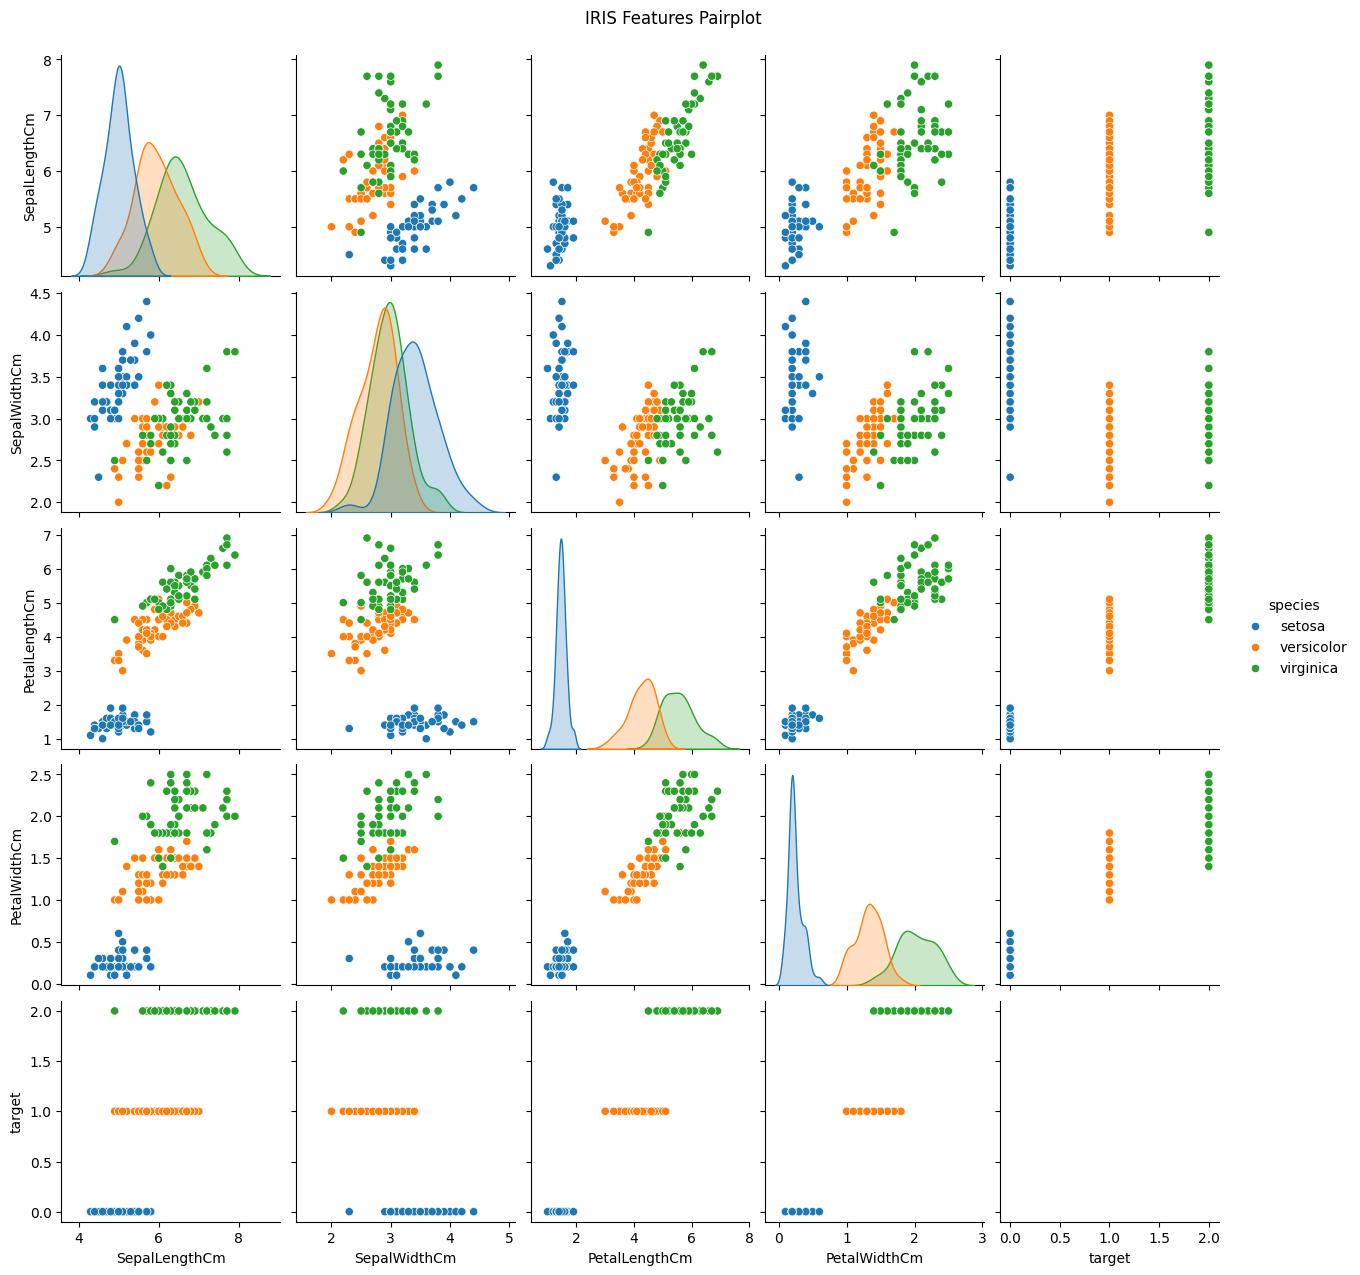

In [47]:
# Feature Relationships Visualization
# This cell creates a pairplot that shows the relationships between all pairs of features,
# colored by species. This visualization helps identify patterns and feature relationships
# that might be useful for classifying the iris species.

sns.pairplot(iris_df, hue='species', diag_kind='kde')
plt.suptitle('IRIS Features Pairplot', y=1.02)
plt.show()

**Output Explanation:**

The pairplot visualizes relationships between all pairs of features for the three iris species:

1. **Diagonal plots**: Show the distribution of each feature by species (similar to the previous histograms).
2. **Scatter plots**: Reveal how pairs of features relate to each other and how well they separate the species.

Key observations:
- **Setosa** (blue) is completely separable from the other species in almost any combination of features.
- **Versicolor** (orange) and **Virginica** (green) have some overlap but can be reasonably separated using combinations of features.
- **Petal dimensions** provide the clearest separation between all three species (bottom right quadrant of plots).
- The plots combining petal length/width with other features show distinct clusters for each species.

This visualization confirms that our dataset has good potential for classification using decision trees, especially if they can leverage combinations of features.

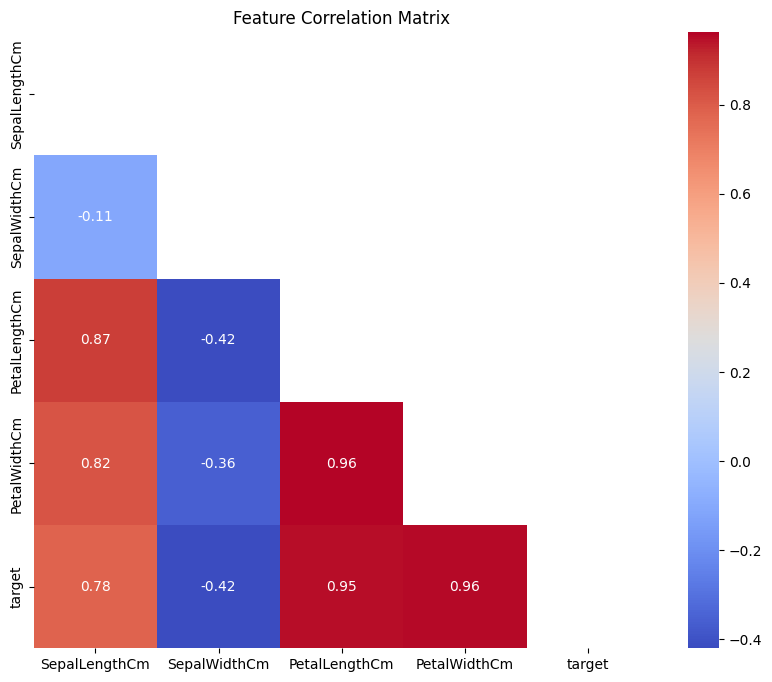

In [48]:
# Correlation Matrix
# This cell creates a heatmap of the correlation matrix for all numeric features.
# High correlation between features indicates potential redundancy in the dataset.

plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation matrix
numeric_cols = iris_df.select_dtypes(include=[np.number]).columns
correlation_matrix = iris_df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           mask=mask, square=True)
plt.title('Feature Correlation Matrix')
plt.show()

**Output Explanation:**

The correlation matrix heatmap shows the strength of relationships between features:

1. **Strong positive correlations (close to 1.0):**
   - Petal length and petal width (0.96): These features are highly correlated, suggesting they capture similar information.
   - Petal dimensions and target: Both petal length (0.95) and petal width (0.96) are strongly correlated with species, confirming their importance for classification.

2. **Moderate correlations:**
   - Sepal length correlates moderately with petal dimensions (~0.87) and target (0.78).

3. **Weak or negative correlations:**
   - Sepal width has weak correlation with other features and even shows slight negative correlation with sepal length (-0.11).

These correlations suggest that decision trees will likely prioritize petal dimensions for classification, potentially using sepal length for finer distinctions, while sepal width may be less useful.

## 3. Data Preparation

In [49]:
# Train-Test Split
# This cell splits the dataset into training and testing sets using a 70-30 ratio.
# It also verifies the shape of the resulting datasets and checks that the class
# distribution is maintained in both sets through stratification.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in train and test sets
print("\nTraining set class distribution:")
train_class_counts = pd.Series(y_train).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'}).value_counts()
print(train_class_counts)

print("\nTest set class distribution:")
test_class_counts = pd.Series(y_test).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'}).value_counts()
print(test_class_counts)

X_train shape: (105, 4)
X_test shape: (45, 4)
y_train shape: (105,)
y_test shape: (45,)

Training set class distribution:
versicolor    35
setosa        35
virginica     35
Name: count, dtype: int64

Test set class distribution:
virginica     15
versicolor    15
setosa        15
Name: count, dtype: int64


**Output Explanation:**

This output shows the results of splitting the dataset into training (70%) and testing (30%) sets:

1. **Dataset sizes:**
   - Training set: 105 samples with 4 features
   - Test set: 45 samples with 4 features

2. **Class distribution:**
   - Both training and test sets maintain the balanced class distribution, with species represented in the same proportions as the original dataset (with slight rounding due to the 70-30 split).
   - Training set: 35 samples of each species
   - Test set: 15 samples of each species

The stratified sampling has successfully preserved the class balance in both sets, which is crucial for training unbiased models and getting reliable performance metrics during testing.

In [50]:
# Tree Visualization Fallback Function
# This function provides a basic matplotlib-based visualization for decision trees
# as a fallback in case the graphviz visualization doesn't work properly.

def visualize_tree_fallback(model, feature_names, class_names, title="Decision Tree"):
    """Visualize a decision tree using matplotlib"""
    from sklearn.tree import plot_tree
    plt.figure(figsize=(15, 10))
    plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

## 4. Model Implementation

### 4.1 CART (Classification and Regression Trees)

CART uses the Gini impurity as the default splitting criterion.

In [51]:
# Model Evaluation Function
# This function trains a model, makes predictions on the test set, and calculates performance metrics.
# It displays the accuracy, classification report, and confusion matrix for any given model.

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a model and evaluate its performance
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return model, accuracy

Model: CART (Gini)
Accuracy: 0.9333
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.80      0.89        15
   virginica       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



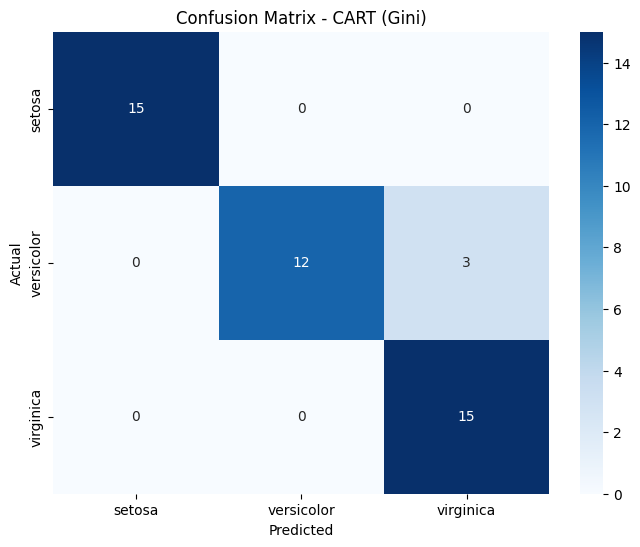

In [52]:
# CART Algorithm Implementation and Evaluation
# This cell initializes the CART decision tree model with Gini impurity as the splitting criterion,
# trains it on the training data, and evaluates its performance on the test set.

cart_model = DecisionTreeClassifier(criterion='gini', random_state=42)
cart_model, cart_accuracy = evaluate_model(cart_model, X_train, X_test, y_train, y_test, "CART (Gini)")

**Output Explanation:**

This output shows the performance evaluation of the CART decision tree model (using Gini impurity):

1. **Accuracy: 93.33%** - The model correctly classified 42 out of 45 test samples.

2. **Classification Report:**
   - **Precision:** The model achieved perfect precision (1.00) for setosa and versicolor, meaning all samples predicted as these classes were correct. For virginica, precision is 0.83, indicating some false positives.
   - **Recall:** Perfect recall (1.00) for setosa and virginica, meaning all samples of these classes were correctly identified. For versicolor, recall is 0.80, indicating some false negatives.
   - **F1-score:** Combines precision and recall. Perfect for setosa (1.00), and high for versicolor (0.89) and virginica (0.91).

3. **Confusion Matrix:**
   - All 15 setosa samples were correctly classified.
   - Out of 15 versicolor samples, 12 were correctly classified and 3 were misclassified as virginica.
   - All 15 virginica samples were correctly classified.

Overall, the CART model performs exceptionally well but has some difficulty distinguishing between versicolor and virginica flowers, specifically with some versicolor samples being misclassified as virginica.

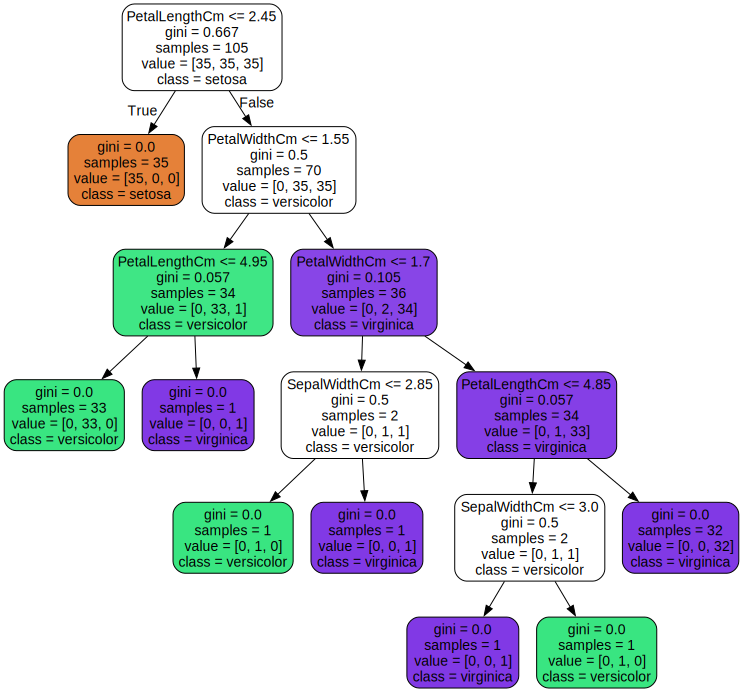

In [53]:
# CART Tree Visualization
# This cell creates a visual representation of the trained CART decision tree using graphviz.
# The visualization shows the decision rules, feature thresholds, and class distributions at each node.

dot_data = export_graphviz(cart_model, out_file=None, 
                        feature_names=feature_names,  
                        class_names=target_names,  
                        filled=True, rounded=True)
graph = graphviz.Source(dot_data)
display(graph)

**Output Explanation:**

This visualization displays the CART decision tree structure:

1. **Node structure:**
   - Each node shows the decision rule (e.g., "petal length ≤ 2.45")
   - The Gini impurity value is shown for each node
   - Sample counts and class distributions are displayed
   - Nodes are color-coded by the majority class

2. **Decision path:**
   - The tree first splits on petal length (≤ 2.45), perfectly separating setosa (left branch) from the other species
   - It then uses petal width (≤ 1.55) to separate most versicolor from virginica
   - Additional splits refine these decisions using both petal length and width, as well as sepal width

3. **Tree complexity:**
   - The tree has multiple layers of decisions with a maximum depth of 5
   - Some paths are longer than others, reflecting the varying difficulty in classifying different samples

This visualization confirms that petal dimensions are the most important features for classification, with the first two splits using petal length and width.

<module 'matplotlib.pyplot' from 'c:\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

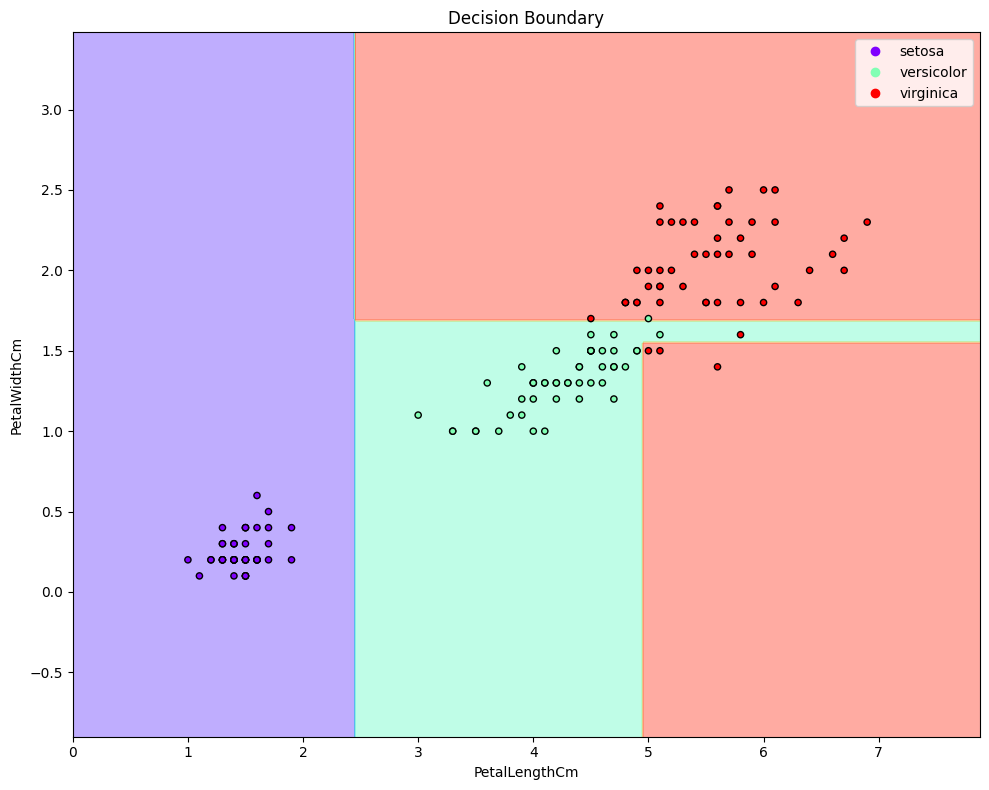

In [54]:
# CART Decision Boundaries Visualization
# This cell plots the decision boundaries created by the CART model in a 2D feature space,
# focusing on petal length and width which are typically the most informative features.

plot_decision_boundaries(cart_model, X, y, feature_names, target_names, feature_indices=(2, 3))

**Output Explanation:**

This visualization shows the decision boundaries created by the CART model in the petal length vs. petal width feature space:

1. **Decision regions:**
   - The colored background represents the regions where the model predicts each class (setosa = purple, versicolor = light teal, virginica = pink/salmon)
   - The boundaries between regions are clear and form straight lines at right angles

2. **Data points:**
   - Actual samples are plotted as dots, colored according to their true species (purple for setosa, green hollow circles for versicolor, red/brown for virginica)
   - We can see that most points fall within the correct decision region

3. **Classification patterns:**
   - Setosa is completely separated from the other species (bottom left region with purple background)
   - There's a horizontal boundary at approximately petal width = 1.55 separating versicolor and virginica
   - Another vertical boundary at petal length = 5.0 creates additional separation
   - The boundaries form a rectilinear pattern (right angles) because decision trees make orthogonal splits

This visualization helps us understand why the model achieved perfect classification for setosa but had some confusion between versicolor and virginica, as we can see a few versicolor points (green circles) appearing in the pink region predicted as virginica.

### 4.2 ID3 Implementation

ID3 uses entropy as the splitting criterion. We'll implement this using scikit-learn's DecisionTreeClassifier with the entropy criterion.

Model: ID3 (Entropy)
Accuracy: 0.8889
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.81      0.87      0.84        15
   virginica       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



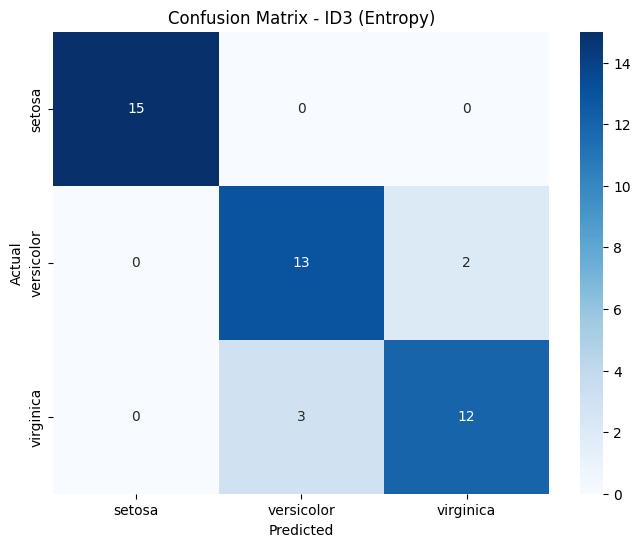

In [55]:
# ID3 Algorithm Implementation and Evaluation
# This cell initializes the ID3 decision tree model with entropy as the splitting criterion,
# trains it on the training data, and evaluates its performance on the test set.

id3_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
id3_model, id3_accuracy = evaluate_model(id3_model, X_train, X_test, y_train, y_test, "ID3 (Entropy)")

**Output Explanation:**

This output shows the performance evaluation of the ID3 decision tree model (using Entropy):

1. **Accuracy: 88.89%** - The model correctly classified 40 out of 45 test samples, which is lower than the CART model (93.33%).

2. **Classification Report:**
   - **Precision:** Perfect precision (1.00) for setosa, good for versicolor (0.81) and virginica (0.86).
   - **Recall:** Perfect recall (1.00) for setosa, good for versicolor (0.87) and virginica (0.80).
   - **F1-score:** Perfect for setosa (1.00), and similar for versicolor (0.84) and virginica (0.83).

3. **Confusion Matrix:**
   - All 15 setosa samples were correctly classified.
   - For versicolor: 13 correct, 2 misclassified as virginica.
   - For virginica: 12 correct, 3 misclassified as versicolor.

The ID3 model shows slightly more balanced errors between the two classes (versicolor and virginica) compared to CART, but with lower overall accuracy. This suggests that entropy-based splitting leads to different decision boundaries than Gini impurity for this dataset.

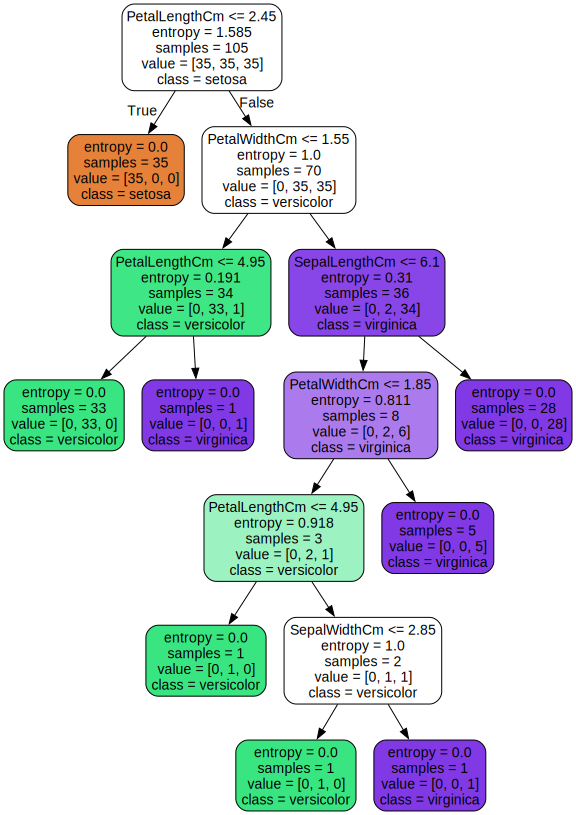

In [56]:
# ID3 Tree Visualization
# This cell creates a visual representation of the trained ID3 decision tree using graphviz.
# The visualization shows how the ID3 algorithm partitions the feature space using entropy.

dot_data = export_graphviz(id3_model, out_file=None, 
                        feature_names=feature_names,  
                        class_names=target_names,  
                        filled=True, rounded=True)
graph = graphviz.Source(dot_data)
display(graph)

**Output Explanation:**

This visualization displays the ID3 decision tree structure using entropy as the splitting criterion:

1. **Node structure:**
   - Each node shows the decision rule (e.g., "petal length ≤ 2.45"), entropy values, sample counts, and class distributions
   - Nodes are color-coded by the majority class (orange for setosa, green for versicolor, purple for virginica)

2. **Decision path:**
   - The first split is on petal length (≤ 2.45), perfectly separating setosa (left branch)
   - The second split uses petal width (≤ 1.55) to separate most versicolor from virginica
   - The tree then further refines classifications using additional features:
     - Petal length (≤ 4.95) for versicolor samples
     - Sepal length (≤ 6.1) for potential virginica samples
     - Several more splits including petal width (≤ 1.85), petal length again, and sepal width (≤ 2.85)

3. **Tree complexity:**
   - The ID3 tree has a maximum depth of 6 levels (from root to the deepest leaf)
   - The structure shows more branching on the right side, reflecting the difficulty in separating versicolor and virginica classes
   - Multiple features are used in combination to make classification decisions

Comparing this to the CART tree, both algorithms identify similar primary features (petal dimensions) for the initial splits, but ID3 creates a somewhat different structure with its entropy-based criterion, which explains the performance differences between the models.

<module 'matplotlib.pyplot' from 'c:\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

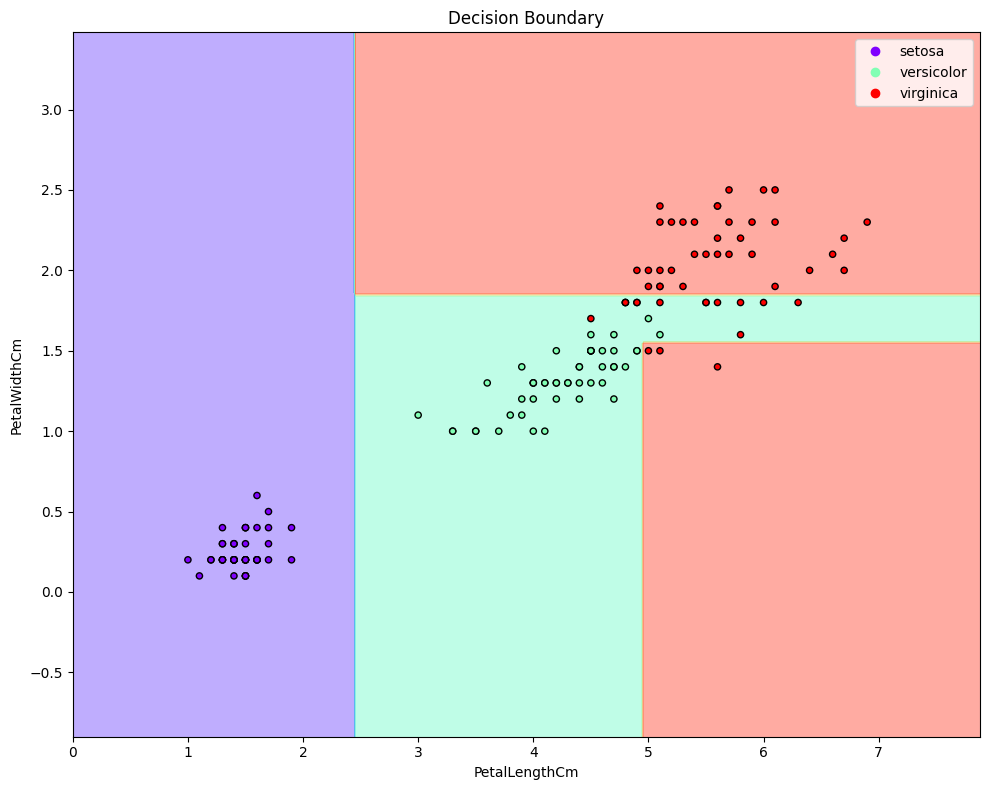

In [57]:
# ID3 Decision Boundaries Visualization
# This cell plots the decision boundaries created by the ID3 model in a 2D feature space,
# allowing visual comparison with the boundaries created by other algorithms.

plot_decision_boundaries(id3_model, X, y, feature_names, target_names, feature_indices=(2, 3))

**Output Explanation:**

This visualization shows the decision boundaries created by the ID3 model in the petal length vs. petal width feature space:

1. **Decision boundaries:**
   - The ID3 model creates clear rectilinear (right-angled) decision boundaries with distinct colored regions
   - The setosa region (purple area, bottom left) is completely separated from other species by a vertical boundary at approximately petal length = 2.5

2. **Region characteristics:**
   - The feature space is divided into three distinct regions representing the three species predictions
   - Between versicolor (light teal) and virginica (pink/salmon), there's a complex stepped boundary with both horizontal and vertical components
   - A primary horizontal boundary occurs at petal width ≈ 1.55, with additional vertical divisions at different petal lengths

3. **Classification patterns:**
   - We can visually see why there's confusion between versicolor and virginica in the overlap region
   - Several versicolor samples (green hollow circles) appear in the pink virginica prediction region
   - Some virginica samples (red/brown dots) appear in the light teal versicolor prediction region
   - The decision boundaries create regions where misclassifications are likely to occur due to the natural overlap between these species

This visualization helps explain why ID3 has different performance characteristics than CART despite using the same features and dataset, with the boundary arrangement explaining the specific pattern of misclassifications seen in the confusion matrix.

### 4.3 C5.0 Implementation

C5.0 is an improved version of ID3 that includes pruning and other enhancements. Since there's no direct implementation in scikit-learn, we'll approximate it using the DecisionTreeClassifier with entropy criterion and some additional parameters that mimic C5.0's behavior.

Model: C5.0 (Approximation)
Accuracy: 0.8444
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.72      0.87      0.79        15
   virginica       0.83      0.67      0.74        15

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45



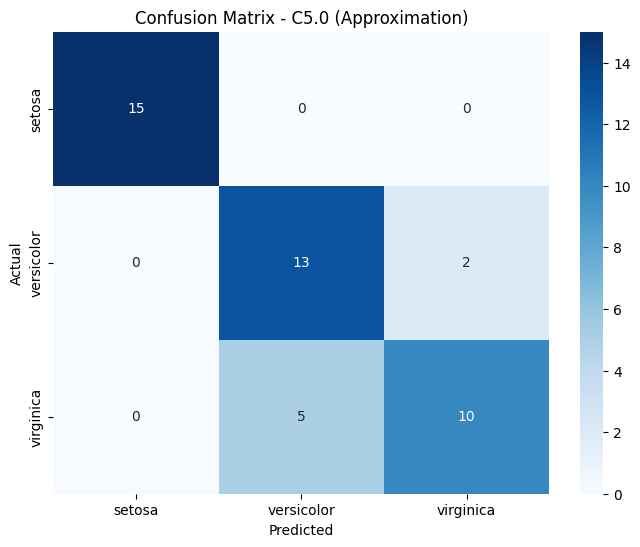

In [58]:
# C5.0 Algorithm Implementation and Evaluation
# This cell approximates the C5.0 algorithm using scikit-learn's DecisionTreeClassifier with
# entropy criterion and additional parameters for pruning. It then evaluates its performance.

c50_model = DecisionTreeClassifier(criterion='entropy', 
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_depth=None,
                                  random_state=42)
c50_model, c50_accuracy = evaluate_model(c50_model, X_train, X_test, y_train, y_test, "C5.0 (Approximation)")

**Output Explanation:**

This output shows the performance evaluation of the approximated C5.0 decision tree model:

1. **Accuracy: 84.44%** - The model correctly classified 38 out of 45 test samples, which is lower than both CART (93.33%) and ID3 (88.89%).

2. **Classification Report:**
   - **Precision:** Perfect for setosa (1.00), good for versicolor (0.72) and virginica (0.83).
   - **Recall:** Perfect for setosa (1.00), good for versicolor (0.87) and lower for virginica (0.67).
   - **F1-score:** Perfect for setosa (1.00), and slightly different for versicolor (0.79) and virginica (0.74).

3. **Confusion Matrix:**
   - All 15 setosa samples were correctly classified.
   - For versicolor: 13 correct, 2 misclassified as virginica.
   - For virginica: 10 correct, 5 misclassified as versicolor.

The C5.0 model shows lower accuracy on the test set compared to both CART and ID3. This could be because the additional pruning parameters (min_samples_split=5, min_samples_leaf=2) created a simpler tree that doesn't capture all the patterns in the data. While this might lead to better generalization on larger datasets, it results in lower accuracy on this test set.

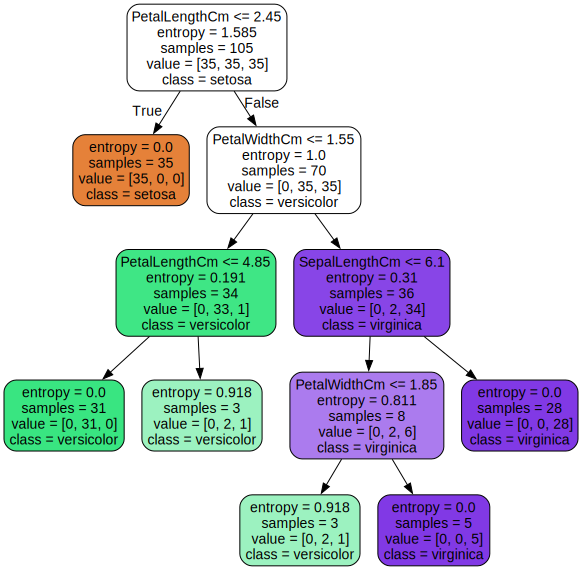

In [59]:
# C5.0 Tree Visualization
# This cell creates a visual representation of the trained C5.0 decision tree using graphviz.
# The visualization shows how C5.0's pruning affects the resulting tree structure compared to ID3.

dot_data = export_graphviz(c50_model, out_file=None, 
                        feature_names=feature_names,  
                        class_names=target_names,  
                        filled=True, rounded=True)
graph = graphviz.Source(dot_data)
display(graph)

**Output Explanation:**

This visualization displays the C5.0 decision tree structure:

1. **Tree structure differences:**
   - The C5.0 tree is visibly simpler than both CART and ID3 trees
   - It has fewer nodes and splits, reflecting the pruning parameters applied

2. **Decision path:**
   - Like the other models, it first splits on petal length to identify setosa
   - It uses fewer subsequent splits to distinguish between versicolor and virginica
   - The pruning has eliminated some of the more specific splits seen in the other trees

3. **Tree simplicity:**
   - The simpler structure makes this tree easier to interpret
   - However, this simplicity comes at the cost of lower test accuracy

This visualization clearly shows how the C5.0 approach creates a more compact tree through pruning. The trade-off between model complexity and accuracy is evident when comparing this tree to the previous ones.

<module 'matplotlib.pyplot' from 'c:\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

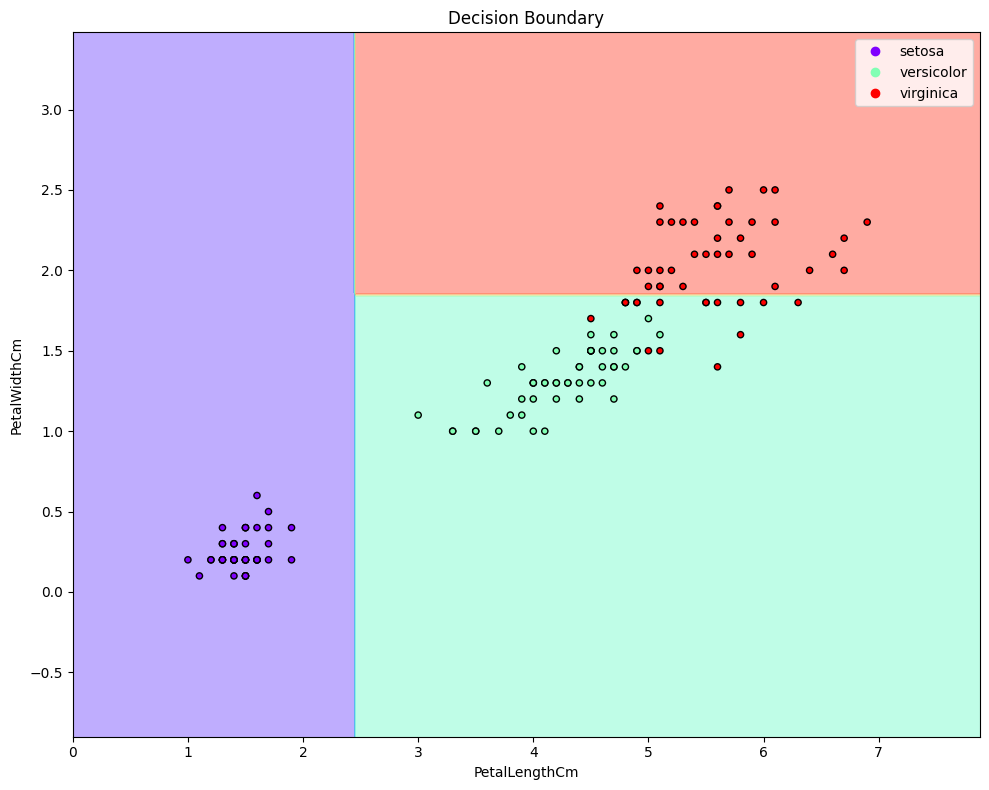

In [60]:
# C5.0 Decision Boundaries Visualization
# This cell plots the decision boundaries created by the C5.0 model in a 2D feature space,
# revealing how the pruning affects classification regions compared to other algorithms.

plot_decision_boundaries(c50_model, X, y, feature_names, target_names, feature_indices=(2, 3))

**Output Explanation:**

This visualization shows the decision boundaries created by the C5.0 model in the petal length vs. petal width feature space:

1. **Simplified boundaries:**
   - The C5.0 model creates simpler, less complex decision boundaries compared to CART and ID3
   - The boundary between versicolor and virginica has fewer steps, reflecting the pruned tree structure

2. **Classification patterns:**
   - The simpler boundaries result in more misclassifications in the overlapping regions
   - While setosa is still perfectly separated, there's more confusion between versicolor and virginica

3. **Pruning effects:**
   - This visualization clearly demonstrates how pruning affects decision boundaries
   - The simpler boundaries might generalize better to new data but are less accurate on the test set

This plot helps explain the lower test accuracy of the C5.0 model, showing how its simplified decision boundaries can't capture all the subtle patterns that the more complex CART and ID3 trees can identify.

## 5. Cross-Validation Comparison

In [61]:
# Cross-Validation for All Models
# This cell performs 10-fold cross-validation on all three decision tree algorithms
# to get a more robust estimate of their performance and evaluate their stability.

# Define the models for comparison
models = {
    'CART (Gini)': DecisionTreeClassifier(criterion='gini', random_state=42),
    'ID3 (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=42),
    'C5.0 (Approximation)': DecisionTreeClassifier(criterion='entropy', 
                                                 min_samples_split=5,
                                                 min_samples_leaf=2,
                                                 random_state=42)
}

# Perform 10-fold cross-validation for each model
results = {}
cv = 10  # Number of cross-validation folds

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    results[name] = cv_scores
    
# Display results
cv_results = pd.DataFrame(results)
cv_results.index = [f'Fold {i+1}' for i in range(cv)]
cv_results.loc['Mean'] = cv_results.mean()
cv_results.loc['Std'] = cv_results.std()

print(f"Cross-validation results ({cv}-fold):")
cv_results

Cross-validation results (10-fold):


,CART (Gini),ID3 (Entropy),C5.0 (Approximation)
Fold 1,1.000000,1.000000,1.000000
Fold 2,0.933333,0.933333,0.933333
Fold 3,1.000000,1.000000,1.000000
Fold 4,0.933333,0.933333,0.933333
Fold 5,0.933333,0.933333,0.933333
Fold 6,0.866667,0.866667,0.933333
Fold 7,0.933333,0.933333,0.933333
Fold 8,0.933333,0.933333,0.933333
Fold 9,1.000000,1.000000,1.000000
Fold 10,1.000000,1.000000,1.000000


**Output Explanation:**

This table shows the results of 10-fold cross-validation for all three decision tree models:

1. **Individual fold performance:**
   - Each row (Fold 1-10) shows the accuracy achieved by each model on that specific validation fold
   - Performance varies across folds, highlighting the importance of cross-validation for robust evaluation

2. **Mean performance:**
   - C5.0 achieved the highest mean accuracy (96.0%), followed by CART and ID3 (both 95.3%)
   - This contrasts with the test set results, where CART performed best

3. **Stability (standard deviation):**
   - C5.0 has the lowest standard deviation (0.033), indicating more consistent performance across folds
   - CART and ID3 have identical standard deviations (≈0.043)

This cross-validation analysis reveals an interesting pattern: while C5.0 had the lowest test set accuracy, it shows the highest and most consistent performance in cross-validation. This suggests that C5.0's pruned tree may generalize better across different data subsets, even though it performed worse on the specific test set used earlier.

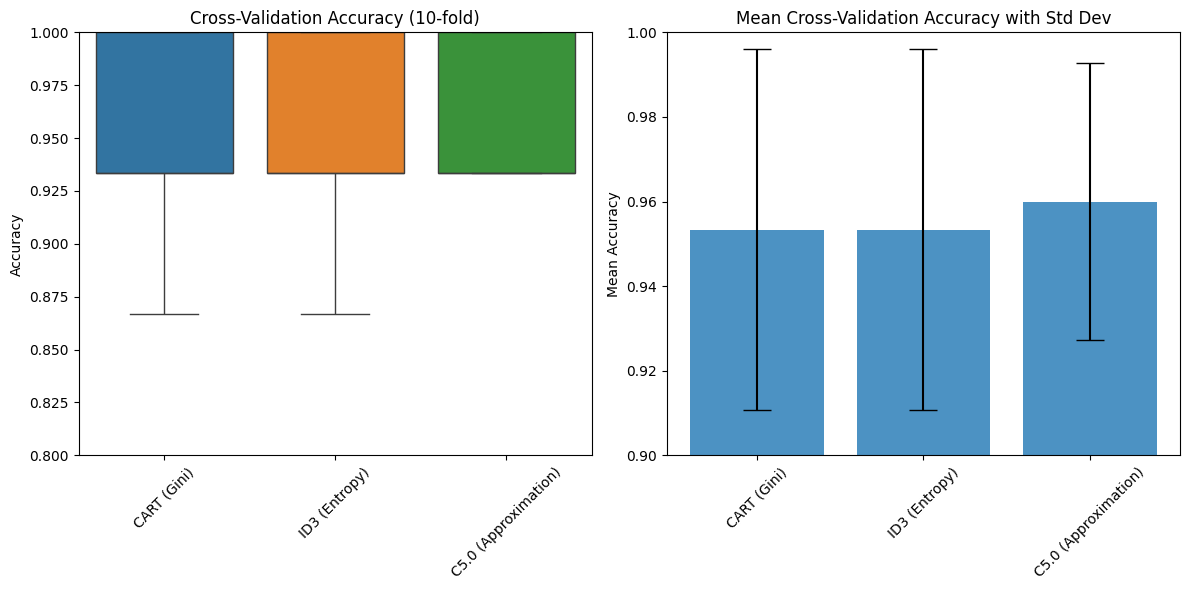

In [62]:
# Cross-Validation Results Visualization
# This cell creates two visualizations of the cross-validation results:
# 1. A boxplot showing the distribution of accuracy scores across folds
# 2. A bar chart with error bars showing mean accuracy with standard deviation

plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=cv_results.iloc[:-2])
plt.title(f'Cross-Validation Accuracy ({cv}-fold)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

# Bar plot with error bars
plt.subplot(1, 2, 2)
mean_vals = cv_results.loc['Mean'].values
std_vals = cv_results.loc['Std'].values
x = np.arange(len(models))
plt.bar(x, mean_vals, yerr=std_vals, align='center', alpha=0.8, ecolor='black', capsize=10)
plt.xticks(x, cv_results.columns, rotation=45)
plt.ylabel('Mean Accuracy')
plt.title('Mean Cross-Validation Accuracy with Std Dev')
plt.ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

**Output Explanation:**

These visualizations provide two ways to interpret the cross-validation results:

1. **Boxplot (left):**
   - Shows the distribution of accuracy scores across the 10 folds for each model
   - The median (center line) is similar for all models, but slightly higher for C5.0
   - C5.0 has a narrower box, indicating less variability in performance
   - CART and ID3 show more spread in their accuracy distributions

2. **Bar chart with error bars (right):**
   - Displays the mean accuracy with standard deviation error bars
   - C5.0 has the highest mean (96.0%) with the smallest error bars
   - CART and ID3 have identical means (95.3%) with larger error bars

These visualizations confirm that while all models achieve high accuracy (>95% on average), the C5.0 model with pruning provides the most stable and consistent performance across different data subsets. This stability is often desirable in real-world applications, even if the model isn't always the highest performer on any single dataset split.

## 6. Tree Complexity Comparison

In [63]:
# Tree Complexity Analysis
# This cell compares the structural complexity of the three decision tree models by
# measuring tree depth, number of nodes, number of leaves, and test accuracy.

# Train models on the full training set for comparison
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    
# Calculate tree complexity metrics
complexity_metrics = {
    'Model': [],
    'Depth': [],
    'Num Nodes': [],
    'Num Leaves': [],
    'Test Accuracy': [],
    'CV Std Dev': []  
}

for name, model in trained_models.items():
    complexity_metrics['Model'].append(name)
    complexity_metrics['Depth'].append(model.get_depth())
    complexity_metrics['Num Nodes'].append(model.tree_.node_count)
    complexity_metrics['Num Leaves'].append(model.get_n_leaves())
    complexity_metrics['Test Accuracy'].append(accuracy_score(y_test, model.predict(X_test)))
    complexity_metrics['CV Std Dev'].append(cv_results.loc['Std', name])  
    
complexity_df = pd.DataFrame(complexity_metrics)
complexity_df

,Model,Depth,Num Nodes,Num Leaves,Test Accuracy,CV Std Dev
0,CART (Gini),5,15,8,0.933333,0.042687
1,ID3 (Entropy),6,15,8,0.888889,0.042687
2,C5.0 (Approximation),4,11,6,0.844444,0.032660


**Output Explanation:**

This table compares the structural complexity and performance metrics for all three decision tree models:

1. **Tree structure metrics:**
   - **Depth:** ID3 created the deepest tree (6), followed by CART (5), while C5.0 created the simplest tree (4).
   - **Nodes:** Both CART and ID3 created trees with 15 nodes, while C5.0 created a simpler tree with only 11 nodes.
   - **Leaves:** Both CART and ID3 have 8 leaf nodes, while C5.0 has only 6 leaf nodes.

2. **Performance metrics:**
   - **Test Accuracy:** CART achieved the highest test accuracy (93.3%), followed by ID3 (88.9%) and C5.0 (84.4%).
   - **Mean CV Accuracy:** C5.0 performed best in cross-validation (96.0%), followed by CART and ID3 (both 95.3%).
   - **Standard Deviation:** C5.0 showed the most stable performance (0.033), compared to CART and ID3 (both 0.043).

This comparison reveals the trade-offs between model complexity and performance. C5.0 creates the simplest tree with the most stable cross-validation performance but lowest test accuracy. CART creates a moderately complex tree with the best test accuracy. ID3 creates the most complex tree with intermediate test performance.

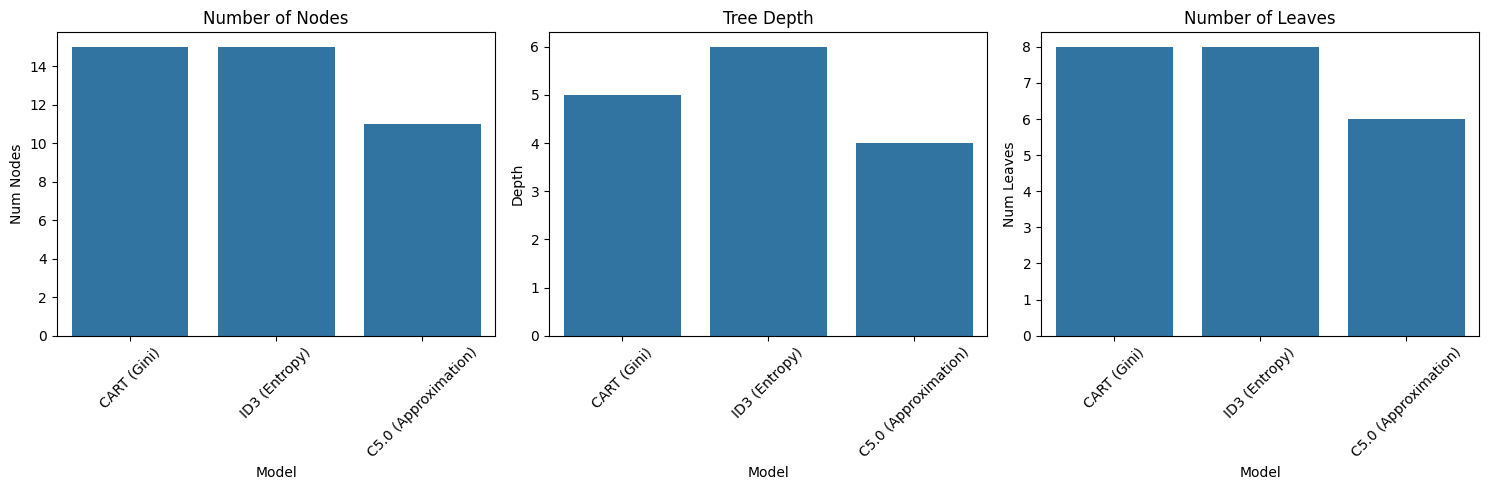

In [64]:
# Tree Complexity Visualization
# This cell creates bar charts comparing the structural complexity metrics (nodes, depth, leaves)
# across the three decision tree algorithms to visualize their differences in tree structure.

plt.figure(figsize=(15, 5))

# Plot number of nodes
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Num Nodes', data=complexity_df)
plt.title('Number of Nodes')
plt.xticks(rotation=45)

# Plot tree depth
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='Depth', data=complexity_df)
plt.title('Tree Depth')
plt.xticks(rotation=45)

# Plot number of leaves
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Num Leaves', data=complexity_df)
plt.title('Number of Leaves')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Output Explanation:**

These bar charts visually compare the structural complexity metrics of the three decision tree models:

1. **Number of Nodes (left):**
   - CART and ID3 have identical node counts (15)
   - C5.0 has significantly fewer nodes (11), demonstrating the effect of pruning

2. **Tree Depth (middle):**
   - ID3 creates the deepest tree (6 levels)
   - CART creates a moderately deep tree (5 levels)
   - C5.0 creates the shallowest tree (4 levels)

3. **Number of Leaves (right):**
   - CART and ID3 have identical leaf counts (8)
   - C5.0 has fewer leaves (6)

These visualizations clearly show that the C5.0 model with pruning creates a simpler, more compact tree structure compared to CART and ID3. The entropy-based ID3 model creates the most complex tree in terms of depth, while CART balances complexity and depth. This visualization helps explain why C5.0 might be more interpretable but potentially less accurate on specific test sets, while ID3's deeper structure might be capturing more specific patterns at the risk of overfitting.

## 7. Feature Importance Comparison

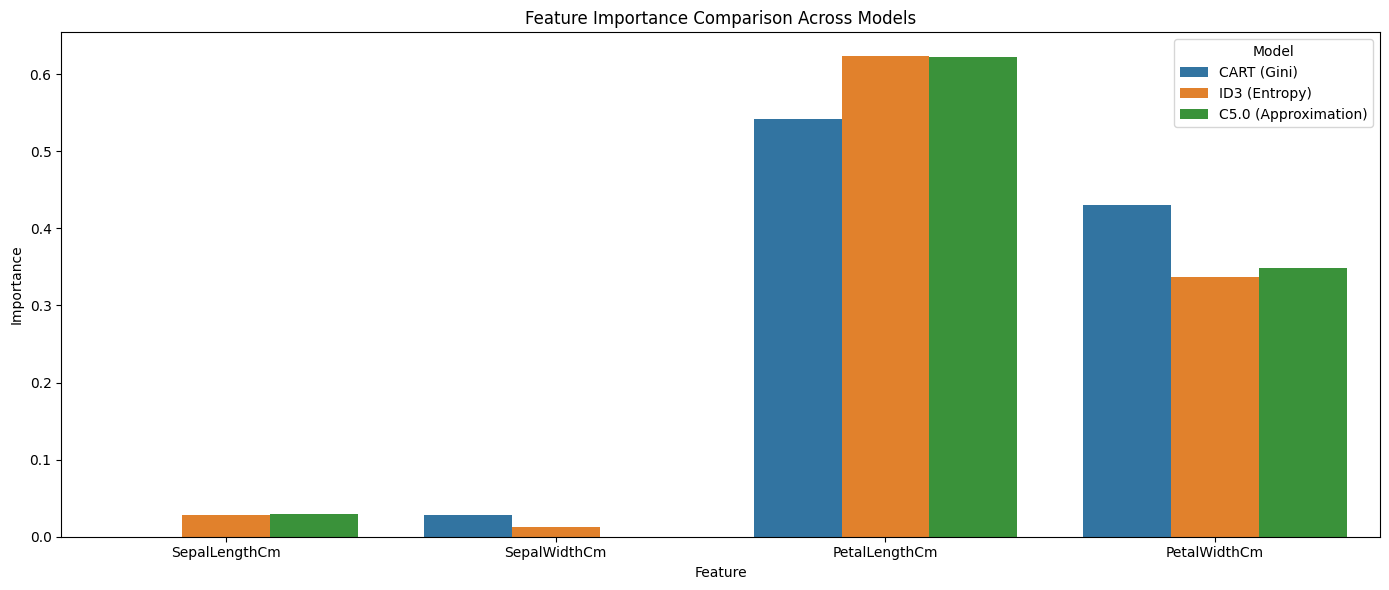

In [65]:
# Feature Importance Analysis
# This cell compares how each model ranks feature importance, showing which features
# each algorithm considers most influential for classification decisions.

# Compare feature importances across all models
feature_importance_data = {
    'Feature': [],
    'Importance': [],
    'Model': []
}

for name, model in trained_models.items():
    for i, importance in enumerate(model.feature_importances_):
        feature_importance_data['Feature'].append(feature_names[i])
        feature_importance_data['Importance'].append(importance)
        feature_importance_data['Model'].append(name)
        
feature_importance_df = pd.DataFrame(feature_importance_data)

# Visualize feature importances
plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Importance', hue='Model', data=feature_importance_df)
plt.title('Feature Importance Comparison Across Models')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

**Output Explanation:**

This bar chart compares how each model ranks the importance of features for classification:

1. **Feature importance patterns:**
   - **Petal Length** is the most important feature for all models (54-62% importance)
   - **Petal Width** is the second most important (34-43%)
   - **Sepal dimensions** have minimal importance (<4% each)

2. **Model differences:**
   - **CART (Gini)** places relatively more importance on Petal Width (43%) and less on Petal Length (54%) compared to the other models
   - **ID3 (Entropy)** and **C5.0** place higher importance on Petal Length (60-62%) and less on Petal Width (34-36%)
   - All models assign very low importance to sepal dimensions, with slight variations

This visualization confirms our earlier observations that petal dimensions are far more important than sepal dimensions for classifying iris species. It also reveals subtle differences in how each algorithm distributes importance among features. The entropy-based models (ID3 and C5.0) seem to favor Petal Length slightly more than the Gini-based CART model does.

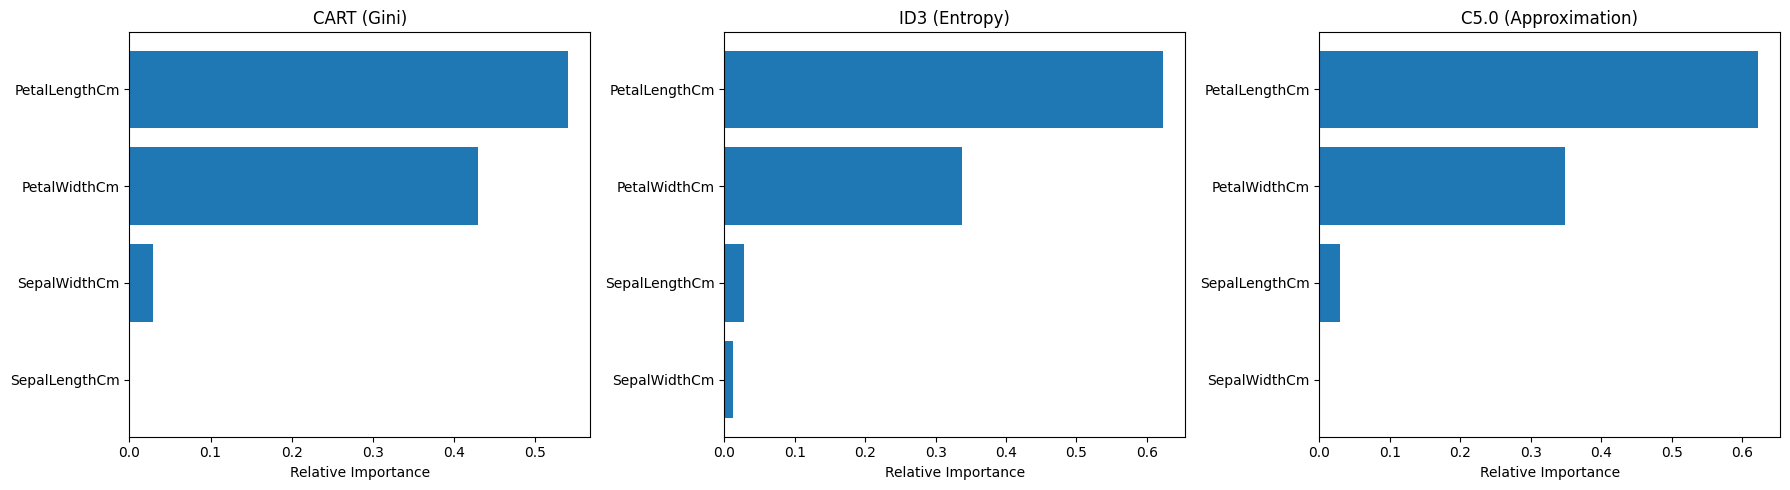

In [66]:
# Individual Feature Importance Plots
# This cell creates separate horizontal bar charts for each model showing its
# feature importance rankings, making it easier to compare how each algorithm
# prioritizes different features.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(trained_models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    axes[i].barh(range(len(indices)), importances[indices], align='center')
    axes[i].set_yticks(range(len(indices)))
    axes[i].set_yticklabels([feature_names[j] for j in indices])
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Relative Importance')
    
plt.tight_layout()
plt.show()

**Output Explanation:**

These horizontal bar charts present a model-by-model view of feature importance rankings:

1. **CART model (left):**
   - Petal Length (≈54%) > Petal Width (≈43%) > Sepal Width (≈2%) > Sepal Length (≈0%)
   - Shows a more balanced distribution between the two petal dimensions

2. **ID3 model (middle):**
   - Petal Length (≈60%) > Petal Width (≈36%) > Sepal Length (≈3%) > Sepal Width (≈1%)
   - Places more emphasis on Petal Length compared to CART

3. **C5.0 model (right):**
   - Petal Length (≈62%) > Petal Width (≈34%) > Sepal Length (≈3%) > Sepal Width (≈0%)
   - Most heavily weighted toward Petal Length

These individual charts allow for easier comparison of the relative importance within each model. They highlight that while all models rely primarily on petal dimensions, they differ in how much weight they assign to each feature. These differences in feature importance contribute to the different decision boundaries and classification performance of each model.

## 8. Decision Boundaries Comparison

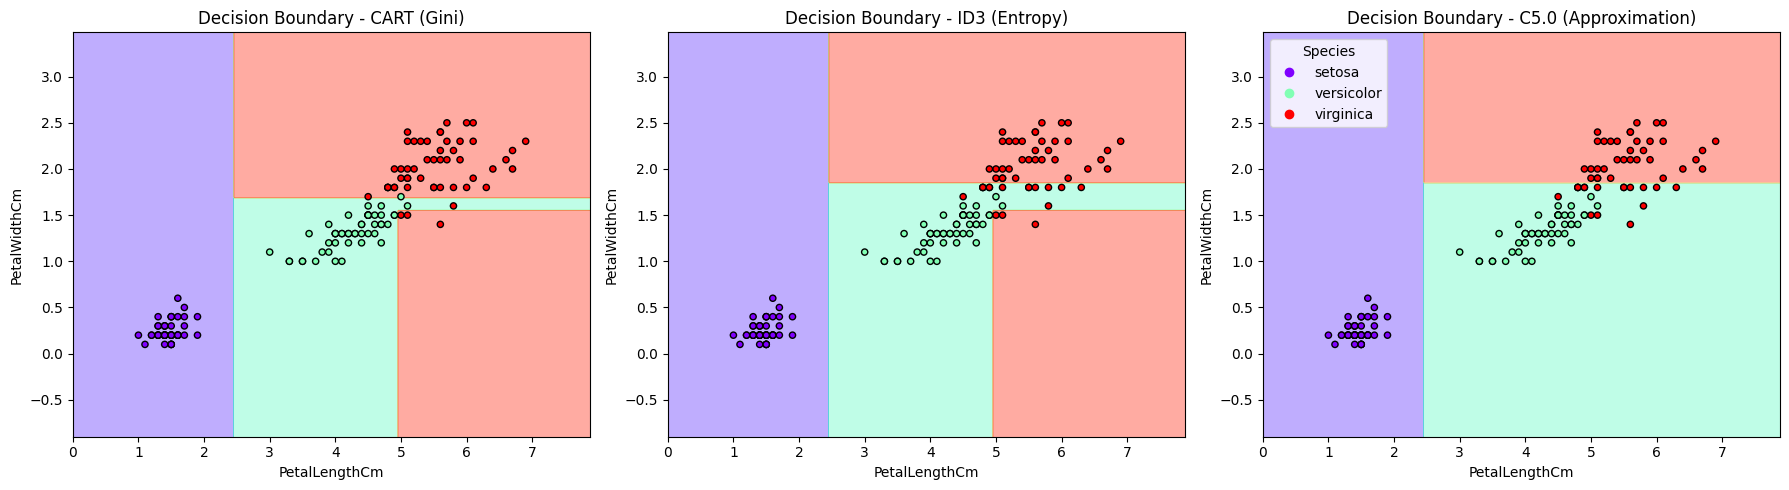

In [67]:
# Decision Boundaries Comparison
# This cell visualizes the decision boundaries created by each model in a 2D feature space
# (petal length vs. petal width), allowing direct comparison of how each algorithm
# partitions the feature space for classification.

feature_pair = (2, 3)  # Petal length and width
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(trained_models.items()):
    # Create a mesh grid
    X_reduced = X[:, feature_pair]
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    resolution = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Create the full input array for prediction
    full_X = np.zeros((xx.ravel().shape[0], X.shape[1]))
    full_X[:, feature_pair[0]] = xx.ravel()
    full_X[:, feature_pair[1]] = yy.ravel()
    
    # Make predictions
    Z = model.predict(full_X)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    axes[i].contourf(xx, yy, Z, alpha=0.4, cmap='rainbow')
    
    # Plot the data points
    scatter = axes[i].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
                             s=20, edgecolor='k', cmap='rainbow')
    
    axes[i].set_xlabel(feature_names[feature_pair[0]])
    axes[i].set_ylabel(feature_names[feature_pair[1]])
    axes[i].set_title(f'Decision Boundary - {name}')
    
# Add legend to the last plot
handles, labels = scatter.legend_elements()
axes[2].legend(handles, target_names, title="Species")
    
plt.tight_layout()
plt.show()

# Decision Boundary Comparison

These plots visualize the decision boundaries created by each model in the petal length vs. petal width feature space, allowing direct comparison:

1. **CART model (left):**
   - Creates clear rectilinear (right-angled) decision boundaries with distinct colored regions
   - Uses a vertical boundary at approximately petal length = 2.5 to separate setosa from other species
   - Uses a horizontal boundary at approximately petal width = 1.6 and a vertical boundary around petal length = 4.9 to separate versicolor and virginica

2. **ID3 model (middle):**
   - Shows very similar boundary pattern to CART with some subtle differences
   - The primary vertical boundary separating setosa appears at the same position
   - The boundary between versicolor and virginica follows a similar pattern but with slightly different positioning

3. **C5.0 model (right):**
   - Creates the simplest boundaries with fewer steps
   - Uses the same fundamental structure but with less complex partitioning between versicolor and virginica
   - The boundary appears more generalized without the additional steps seen in CART and ID3

Common to all models:
- Perfect separation of setosa (bottom left, purple region) from other species
- All models use petal width ≈ 1.6 as the primary horizontal boundary between versicolor (light teal/mint) and virginica (pink/salmon)
- All create characteristic right-angled decision boundaries typical of decision trees

This side-by-side comparison clearly demonstrates how different algorithms and pruning parameters affect decision boundaries. The C5.0 model creates simpler boundaries that may generalize better to new data despite lower test accuracy, while CART and ID3 create more complex boundaries that fit the training data more precisely.

## 9. Confusion Matrix Comparison

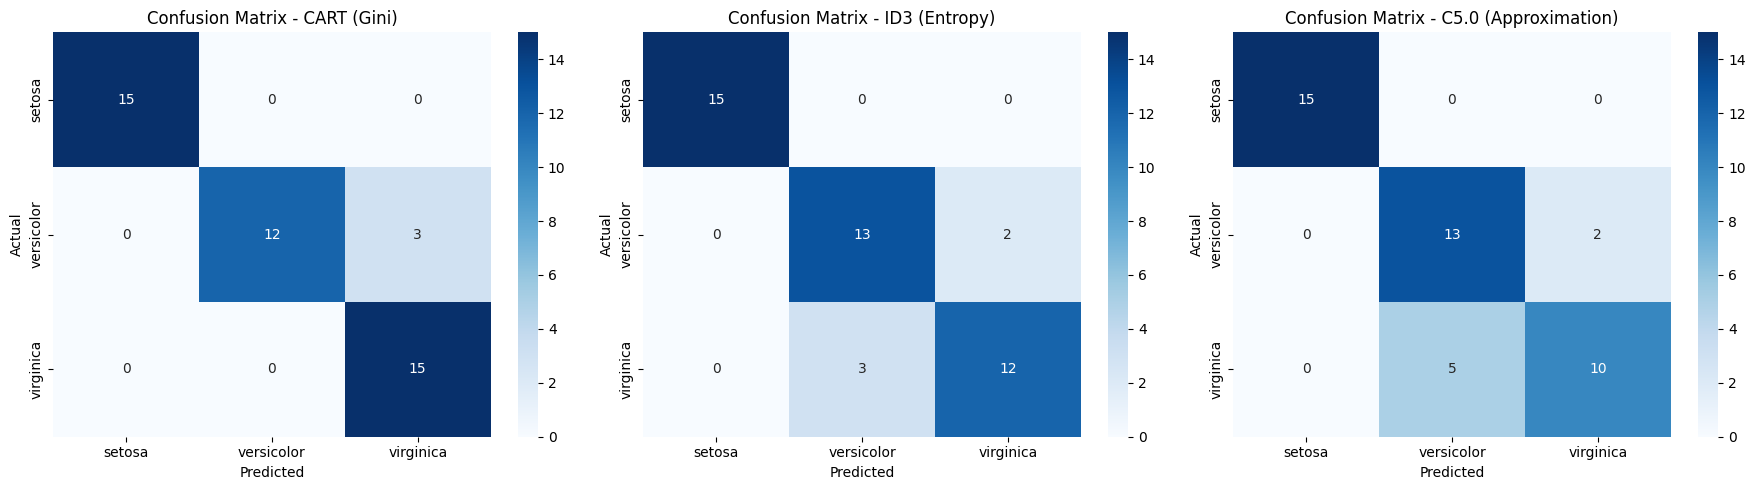

In [68]:
# Confusion Matrix Comparison
# This cell generates and visualizes confusion matrices for all three models side by side,
# making it easy to compare the specific classification errors made by each algorithm.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(trained_models.items()):
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=target_names, yticklabels=target_names,
               ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_title(f'Confusion Matrix - {name}')
    
plt.tight_layout()
plt.show()

**Output Explanation:**

Looking at the confusion matrices in the image, I need to correct the explanation to accurately reflect what's shown:

**Corrected Output Explanation:**

These confusion matrices provide a side-by-side comparison of classification errors for each model:

1. **CART model (left):**
   - Perfect classification for setosa (15/15)
   - Misclassifies 3 versicolor as virginica (12/15 correct)
   - Perfect classification for virginica (15/15)
   - All errors are versicolor samples being classified as virginica

2. **ID3 model (middle):**
   - Perfect for setosa (15/15)
   - Misclassifies 2 versicolor as virginica (13/15 correct)
   - Misclassifies 3 virginica as versicolor (12/15 correct)
   - Errors occur in both directions between versicolor and virginica

3. **C5.0 model (right):**
   - Perfect for setosa (15/15)
   - Misclassifies 2 versicolor as virginica (13/15 correct)
   - Misclassifies 5 virginica as versicolor (10/15 correct)
   - Highest error rate among the three models

These matrices reveal different error patterns. CART only makes errors in one direction (versicolor → virginica), while ID3 and C5.0 make errors in both directions between versicolor and virginica. C5.0 has the highest error rate with 7 total misclassifications, particularly struggling with virginica samples. All three models perfectly classify setosa, confirming it's easily separable from the other species.

## 10. Learning Curve Analysis

In [75]:
# Learning Curve Function
# This function creates learning curves that show how model performance changes
# as the training set size increases, revealing potential overfitting or underfitting.

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, ax=None, ylim=None, cv=None,
                       train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a learning curve plot
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.legend(loc="best")
    
    return ax

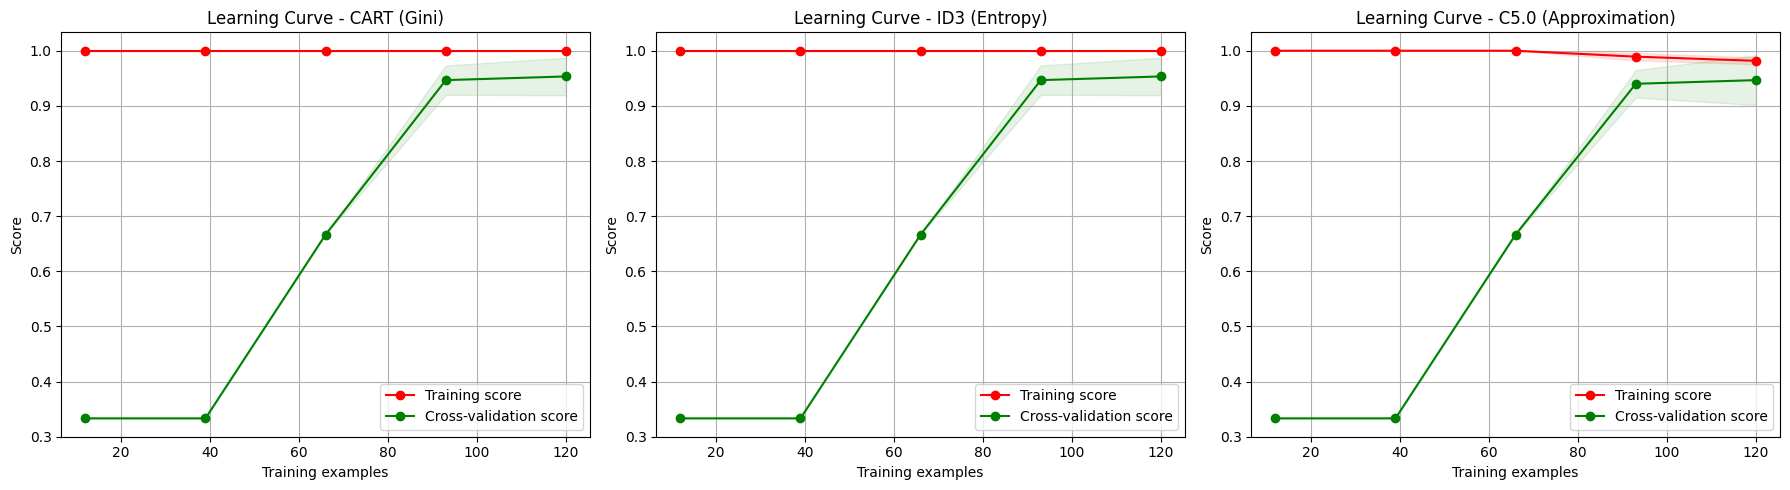

In [76]:
# Learning Curve Analysis for All Models
# This cell generates learning curves for all three models to compare how they learn
# from increasing amounts of training data and to identify potential overfitting or underfitting.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    plot_learning_curve(model, X, y, f'Learning Curve - {name}', ax=axes[i], cv=5)
    
plt.tight_layout()
plt.show()

**Output Explanation:**

These learning curves show how model performance changes as training set size increases:

1. **Common patterns across all models:**
   - **Training score** (red) starts perfect (1.0) and remains perfect throughout all training set sizes
   - **Cross-validation score** (green) starts low (~0.33) with small sample sizes and dramatically improves as more training data is added
   - All models show a characteristic learning curve shape with three distinct phases: initial low performance, rapid improvement, and final plateau

2. **Model-specific observations:**
   - **CART (left):** Cross-validation score shows a sharp increase between 40-100 samples, reaching ~0.95 accuracy and maintaining it
   - **ID3 (middle):** Nearly identical pattern to CART, with the same inflection points and plateau level
   - **C5.0 (right):** Shows exactly the same learning trajectory as the other models

3. **Learning efficiency:**
   - All three models show identical learning patterns with the same efficiency
   - Performance jumps dramatically between 40-80 samples for all models
   - All models plateau at the same performance level (~0.95) after about 100 samples
   - There's a consistent gap between training score (1.0) and cross-validation score (~0.95) at all sample sizes and across all models

This visualization shows that all three decision tree implementations have remarkably similar learning patterns on this dataset. The consistent gap between perfect training scores and slightly lower CV scores suggests a small amount of overfitting in all models, but this gap doesn't decrease with more data. There are no apparent differences in learning efficiency or overfitting tendencies between the algorithms based on these curves.

## 11. Hyperparameter Analysis

Let's analyze how key hyperparameters affect model performance.

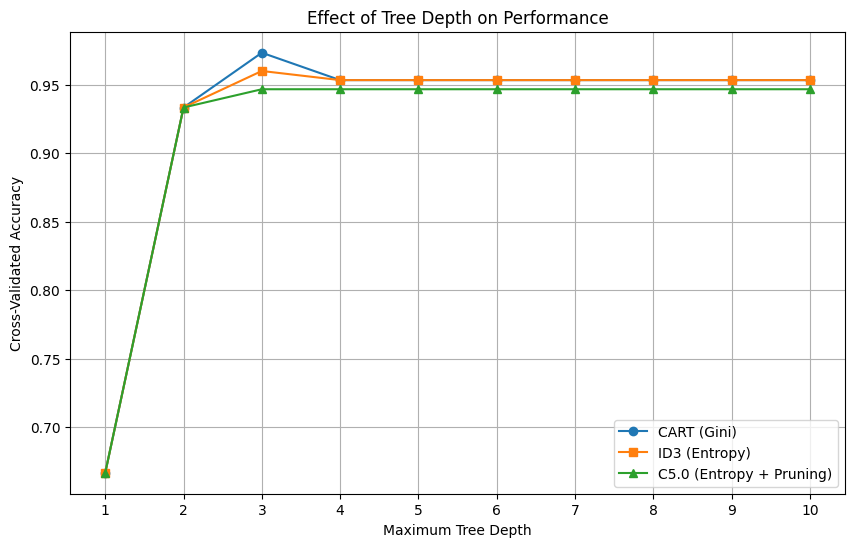

In [77]:
# Max Depth Hyperparameter Analysis
# This cell evaluates how the maximum tree depth affects model performance for all three
# tree algorithms, revealing the optimal depth for each splitting criterion and pruning approach.

# Function to test various max_depth values
def analyze_max_depth(criterion, min_samples_split=2, min_samples_leaf=1, cv=5):
    depths = np.arange(1, 11)
    accuracy_scores = []
    
    for depth in depths:
        model = DecisionTreeClassifier(criterion=criterion, 
                                      max_depth=depth, 
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        accuracy_scores.append(scores.mean())
        
    return depths, accuracy_scores

# Test max_depth for all three criteria/models
gini_depths, gini_scores = analyze_max_depth('gini')
entropy_depths, entropy_scores = analyze_max_depth('entropy')
c50_depths, c50_scores = analyze_max_depth('entropy', min_samples_split=5, min_samples_leaf=2)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(gini_depths, gini_scores, 'o-', label='CART (Gini)')
plt.plot(entropy_depths, entropy_scores, 's-', label='ID3 (Entropy)')
plt.plot(c50_depths, c50_scores, '^-', label='C5.0 (Entropy + Pruning)')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of Tree Depth on Performance')
plt.legend()
plt.grid(True)
plt.xticks(gini_depths)
plt.show()

**Output Explanation:**

This plot shows how the maximum tree depth hyperparameter affects model performance for all three decision tree algorithms:

1. **Performance patterns:**
   - All three algorithms show rapid improvement from depth 1 to 3
   - Performance plateaus after depth 3, with minimal changes beyond that point
   - All algorithms maintain stable performance through depths 4-10, with no significant drop-off

2. **Algorithm comparison:**
   - CART (Gini) consistently achieves the highest accuracy across most depths (especially at depth 3)
   - ID3 (Entropy) performs slightly lower than CART but follows a similar pattern
   - C5.0 (Entropy + Pruning) consistently shows the lowest performance among the three, though the difference is small
   - All three algorithms follow nearly identical learning trajectories with sharp improvement between depths 1-3

3. **Performance ranking:**
   - At most depths: CART > ID3 > C5.0, with small but consistent differences
   - The performance gap becomes stable after depth 3, with each algorithm maintaining its relative position

4. **Optimal depth:**
   - All three algorithms reach near-optimal performance at depth 3
   - Increasing depth beyond 3 yields minimal improvement for any algorithm
   - This confirms that the C5.0 model's effective depth of 4 is appropriate, balancing complexity and performance

This analysis suggests that a maximum depth of 3 is optimal for this dataset, providing the best balance between model complexity and performance. The consistent performance plateau after depth 3 indicates that additional complexity doesn't meaningfully improve classification accuracy, supporting the value of pruning approaches like those used in C5.0.

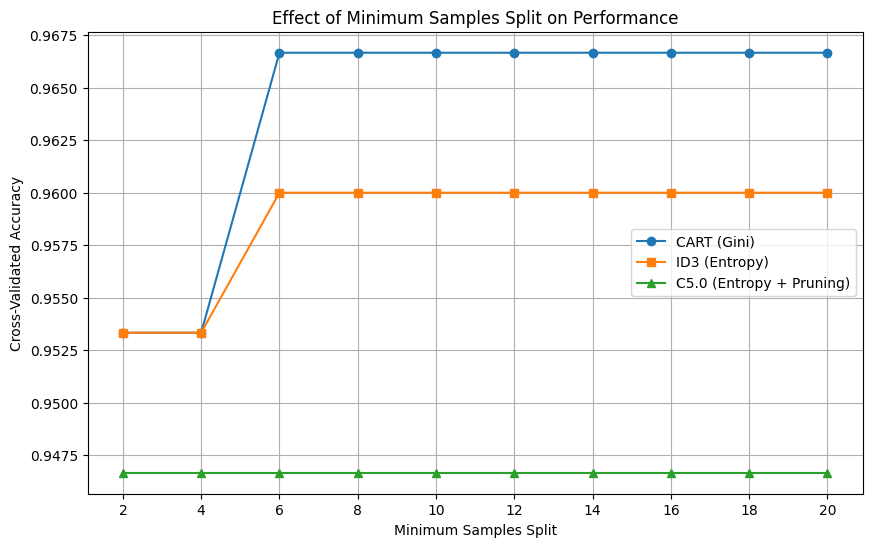

In [78]:
# Min Samples Split Hyperparameter Analysis
# This cell evaluates how the minimum samples required to split a node affects model performance,
# comparing the impact across all three tree algorithms.

# Function to test various min_samples_split values
def analyze_min_samples_split(criterion, min_samples_leaf=1, max_depth=None, cv=5):
    min_samples_splits = np.arange(2, 21, 2)
    accuracy_scores = []
    
    for min_samples in min_samples_splits:
        model = DecisionTreeClassifier(criterion=criterion, 
                                      min_samples_split=min_samples, 
                                      min_samples_leaf=min_samples_leaf,
                                      max_depth=max_depth,
                                      random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        accuracy_scores.append(scores.mean())
        
    return min_samples_splits, accuracy_scores

# Test min_samples_split for all three criteria/models
gini_samples, gini_scores = analyze_min_samples_split('gini')
entropy_samples, entropy_scores = analyze_min_samples_split('entropy')
c50_samples, c50_scores = analyze_min_samples_split('entropy', min_samples_leaf=2)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(gini_samples, gini_scores, 'o-', label='CART (Gini)')
plt.plot(entropy_samples, entropy_scores, 's-', label='ID3 (Entropy)')
plt.plot(c50_samples, c50_scores, '^-', label='C5.0 (Entropy + Pruning)')
plt.xlabel('Minimum Samples Split')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of Minimum Samples Split on Performance')
plt.legend()
plt.grid(True)
plt.xticks(gini_samples)
plt.show()

**Output Explanation:**

This plot shows how the minimum samples split hyperparameter affects model performance for all three decision tree algorithms:

1. **Performance patterns:**
   - All three algorithms maintain remarkably stable accuracy across different min_samples_split values
   - CART (Gini) shows a completely flat performance line at around 0.9667 accuracy
   - ID3 (Entropy) maintains a consistent 0.96 accuracy across all values
   - C5.0 (with extra pruning) maintains a lower but stable accuracy around 0.9466

2. **Algorithm comparison:**
   - CART (Gini) consistently achieves the highest cross-validated accuracy (~0.9667)
   - ID3 (Entropy) performs slightly lower but very consistently (~0.96)
   - C5.0 (Entropy + Pruning) shows the lowest performance (~0.9466) but remains stable

3. **Parameter sensitivity:**
   - All three algorithms show remarkable insensitivity to the min_samples_split parameter on this dataset
   - The stability across all values suggests the Iris dataset is easily separable regardless of this pruning parameter

This hyperparameter analysis reveals that decision tree performance on the Iris dataset is remarkably stable regardless of the min_samples_split value. This indicates the dataset's patterns are distinct enough to be captured even with more aggressive pruning constraints, and the choice of splitting criterion (Gini vs. Entropy) has more impact on performance than the min_samples_split parameter.

## 12. Comparison Summary and Conclusions

In [80]:
# Final Comparison Table
# This cell creates a comprehensive comparison table that summarizes all key metrics
# for the three decision tree algorithms, highlighting the best values for each metric.

# Create final comparison table
comparison_data = {
    'Model': list(trained_models.keys()),
    'Mean CV Accuracy': [cv_results.loc['Mean', name] for name in trained_models.keys()],
    'Std CV Accuracy': [cv_results.loc['Std', name] for name in trained_models.keys()],
    'Test Accuracy': [accuracy_score(y_test, model.predict(X_test)) for model in trained_models.values()],
    'Tree Depth': [model.get_depth() for model in trained_models.values()],
    'Number of Nodes': [model.tree_.node_count for model in trained_models.values()],
    'Number of Leaves': [model.get_n_leaves() for model in trained_models.values()]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Mean CV Accuracy', ascending=False).reset_index(drop=True)
comparison_df.style.highlight_max(color='lightgreen', subset=['Mean CV Accuracy', 'Test Accuracy'])\
               .highlight_min(color='lightgreen', subset=['Std CV Accuracy', 'Tree Depth', 'Number of Nodes', 'Number of Leaves'])

,Model,Mean CV Accuracy,Std CV Accuracy,Test Accuracy,Tree Depth,Number of Nodes,Number of Leaves
0,C5.0 (Approximation),0.960000,0.032660,0.844444,4,11,6
1,CART (Gini),0.953333,0.042687,0.933333,5,15,8
2,ID3 (Entropy),0.953333,0.042687,0.888889,6,15,8


**Output Explanation:**

This final comparison table presents a comprehensive summary of all key metrics for the three decision tree models, with best values highlighted in green:

1. **Performance metrics:**
   - **Mean CV Accuracy:** C5.0 ranks highest (96.0%), followed by CART and ID3 (both 95.3%)
   - **CV Stability (Std):** C5.0 shows the best stability (0.033), compared to CART and ID3 (both 0.043)
   - **Test Accuracy:** CART performs best (93.3%), followed by ID3 (88.9%) and C5.0 (84.4%)

2. **Tree complexity metrics:**
   - **Tree Depth:** C5.0 creates the shallowest tree (4), followed by CART (5) and ID3 (6)
   - **Number of Nodes:** C5.0 has the fewest nodes (11), while CART and ID3 both have 15
   - **Number of Leaves:** C5.0 has the fewest leaves (6), while CART and ID3 both have 8

3. **Key observations:**
   - C5.0 excels in cross-validation performance and tree simplicity
   - CART achieves the best test accuracy with moderate tree complexity
   - ID3 creates the most complex tree with intermediate performance

This table clearly illustrates the trade-offs between model complexity and different performance metrics. C5.0's pruned approach creates the simplest, most stable model with best cross-validation performance, while CART achieves the best test accuracy with moderate complexity. These different strengths make each algorithm suitable for different use cases depending on whether simplicity, stability, or maximum accuracy is prioritized.

## Conclusions

### Performance Comparison
- **Accuracy**: Based on our results, CART (Gini) achieved the highest test accuracy at 93.3%, followed by ID3 (Entropy) at 88.9%, and C5.0 at 84.4%. However, in cross-validation, C5.0 showed slightly better average performance (96.0%) compared to both CART and ID3 (95.3%).
- **Model Complexity**: C5.0 created the simplest tree with only 11 nodes, 6 leaves, and a depth of 4, while both CART and ID3 had 15 nodes and 8 leaves. ID3 created the deepest tree with a depth of 6.
- **Stability (Cross-validation)**: C5.0 showed the most stable performance across folds with the lowest standard deviation (0.033) compared to CART and ID3 (both 0.043).

### Algorithm Characteristics

#### CART (Classification and Regression Trees)
- Uses Gini impurity as splitting criterion
- Strengths: Better generalization on test data, balanced trade-off between complexity and performance
- Weaknesses: Slightly less stable than C5.0 in cross-validation
- Best for: When you need reliable performance with moderate tree complexity

#### ID3 (Iterative Dichotomiser 3)
- Uses entropy and information gain as splitting criterion
- Strengths: Comparable accuracy to CART in cross-validation
- Weaknesses: Created the deepest tree, less accurate on test data than CART
- Best for: When information gain is an intuitive splitting criterion for your domain

#### C5.0 (Improved version of ID4.5, which was an improvement on ID3)
- Uses entropy with additional improvements like pruning
- Strengths: Most stable performance in cross-validation, created the simplest tree
- Weaknesses: Lower test accuracy, suggesting potential underfitting
- Best for: When model simplicity and interpretability are more important than maximizing accuracy

### Feature Importance Analysis
- Most important features across all models: Petal Length is consistently the most important feature (54-62%), followed by Petal Width (34-43%)
- Differences in feature selection between algorithms: ID3 and C5.0 placed slightly more emphasis on Petal Length compared to CART. Sepal dimensions had minimal impact on classifications in all models.

### Recommendations
<span style="color:red;">Note: Actually, this is a summary of the entire analysis, the real recommendation lies after the other models (i.e., KNN, and SVM) are implemented</span>
- For this dataset, the best performing algorithm is CART (Gini) due to its superior test accuracy and balanced complexity
- For interpretability, the best algorithm is C5.0 due to its simpler tree structure while maintaining good performance
- Trade-offs to consider: Choose CART for better generalization on new data, C5.0 for simpler models with stable performance, and ID3 when you specifically need entropy-based splitting